Importing libraries.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import seaborn as sns

Loading in a dataset of nba teams' end-of-year statistics from 1999-2020. From both basketball reference and NBA.com

In [4]:
dataset = pd.read_csv('historical_teams_data.csv')
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values
titles = dataset.columns

Finding the width of the X array (aka, the number of statistics).

In [5]:
i = len(X[0])
c_arr = np.zeros(i)
d_arr = np.zeros(i)

Finding correlation between every statistic and plotting on heatmap. 

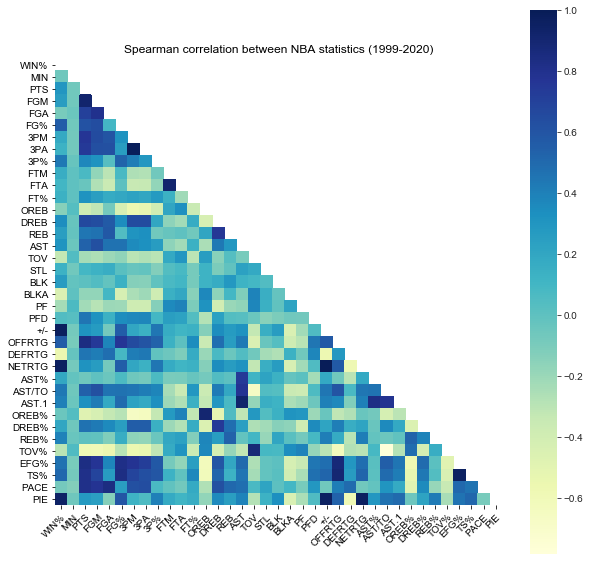

In [6]:
a, b = spearmanr(dataset)
mask = np.zeros_like(a)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,10))  
with sns.axes_style("white"):
    ax = sns.heatmap(a, mask=mask, square=True,  cmap="YlGnBu", ax=ax)
    plt.title('Spearman correlation between NBA statistics (1999-2020)')
    ax.set_xticklabels(titles)
    ax.set_yticklabels(titles)
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    plt.setp(ax.get_yticklabels(), rotation = 360, ha = "right", rotation_mode = "anchor")
    plt.show()

Looping through each statistic and calculating the pearson correlation coefficient to the target statistic, win %. Both of these spit out two values, rho and p-value. Loading these values into appropriate arrays.

In [7]:
for i in range(0,int(i)):
    c, d = pearsonr(X[:,i], y)
    c_arr[i] = c
    d_arr[i] = d

Copied and pasted pearson values into excel to find the top correlated statistics. They were plusminus, net rtg, and pie. Then we move onto the next stage of the project.

Loaded a dataset containing every NBA game since 1999 with their outcome and the difference between the team's plus-minus, net rtg, and pie (all end of year figures, so not 100% accurate).

In [8]:
dataset = pd.read_csv('nba_data.csv')
X = dataset.iloc[:27540, [3, 4, 5]].values
plusminus = dataset.iloc[:27540,3].values
netrtg = dataset.iloc[:27540,4].values
pie = dataset.iloc[:27540,5].values
y = dataset.iloc[:27540, 6].values

Plotting the histogram for all three of these stastics. They are normally distributed, so standardization will be the appropriate feature scaling method.

(array([2.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 7.000e+00, 1.100e+01,
        1.800e+01, 2.300e+01, 6.600e+01, 8.500e+01, 1.200e+02, 1.690e+02,
        3.180e+02, 3.240e+02, 4.640e+02, 5.220e+02, 7.900e+02, 9.250e+02,
        9.700e+02, 1.265e+03, 1.207e+03, 1.580e+03, 1.361e+03, 1.729e+03,
        1.688e+03, 1.865e+03, 1.734e+03, 1.377e+03, 1.591e+03, 1.222e+03,
        1.252e+03, 9.780e+02, 9.410e+02, 7.840e+02, 5.250e+02, 4.590e+02,
        3.290e+02, 3.260e+02, 1.690e+02, 1.220e+02, 8.800e+01, 6.000e+01,
        2.400e+01, 2.000e+01, 1.100e+01, 5.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00]),
 array([-18.9  , -18.144, -17.388, -16.632, -15.876, -15.12 , -14.364,
        -13.608, -12.852, -12.096, -11.34 , -10.584,  -9.828,  -9.072,
         -8.316,  -7.56 ,  -6.804,  -6.048,  -5.292,  -4.536,  -3.78 ,
         -3.024,  -2.268,  -1.512,  -0.756,   0.   ,   0.756,   1.512,
          2.268,   3.024,   3.78 ,   4.536,   5.292,   6.048,   6.804,
          7.56 ,   8.

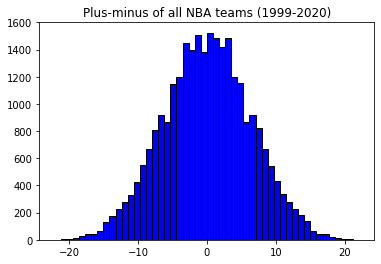

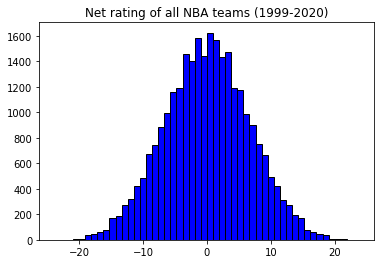

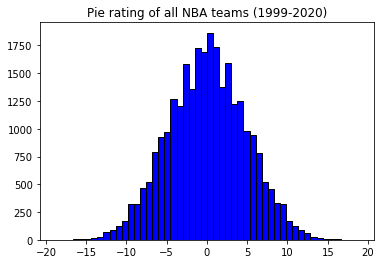

In [9]:
plt.figure(0)
plt.title('Plus-minus of all NBA teams (1999-2020)')
plt.hist(plusminus,color = 'blue', edgecolor = 'black', bins=int(50))
plt.figure(1)
plt.title('Net rating of all NBA teams (1999-2020)')
plt.hist(netrtg,color = 'blue', edgecolor = 'black', bins=int(50))
plt.figure(2)
plt.title('Pie rating of all NBA teams (1999-2020)')
plt.hist(pie,color = 'blue', edgecolor = 'black', bins=int(50))

Fitting the logistic regression to the training set. Hyperparameters were found from gridsearch tuning later on in the code. Using cross-validation to calculate the accuracy.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
classifier = LogisticRegression(solver='saga',C=5)
splits = 5
scores = cross_val_score(classifier, X, y, cv = splits)
y_pred = cross_val_predict(classifier, X, y, cv = splits)
cm = confusion_matrix(y,y_pred)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Confusion Matrix:")
print(cm)

Accuracy: 0.69 (+/- 0.02)
Confusion Matrix:
[[ 5610  5430]
 [ 3138 13362]]


Results were quite heavily skewed. Confusion matrix showed a lot more true positives than there were true negatives which I found hard to believe. On one run, for example, 68% true positives with 32% true negatives. Then I looked into the actual data and found that 60% of the time, the home team wins (1). My data was overpredicting a little bit: 68% of the time, the home team wins (1). I thought that I could do some sort of threshold tuning on this, so I found out that ROC curve analysis can help identify the optimal threshold for somewhat normally distributed samples. In the ROC plot, the optimal threshold is the point on the ROC curve closest to the top left corner.
So I used the true positive rate and false positive rate to calculate G Means and maximized it to identify the optimal threshold. I then plotted this point on the ROC curve. Of course this was performed 5 times as per the cross-validation.

Mean of optimal thresholds is: 0.60


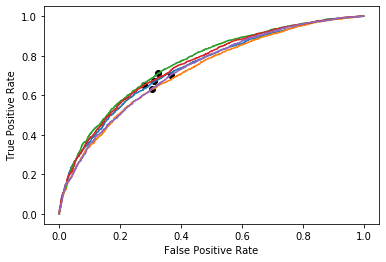

In [11]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from numpy import sqrt
from numpy import argmax

optimal_threshold = np.zeros(splits)
cv = StratifiedKFold (n_splits = splits)
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    y_probs = classifier.predict_proba(X[test])
    y_probs = y_probs[:,1]
    fpr, tpr, thresholds = roc_curve(y[test],y_probs)  
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    optimal_threshold[i] = thresholds[ix]
    plt.plot(fpr, tpr)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
print("Mean of optimal thresholds is: %0.2f" % (optimal_threshold.mean()))

Looped through every value in a new y_pred variable, y_pred_2, to assign a 1 for y_probabilities returned from the logistic regression that are greater than the optimal threshold found in the ROC curve analysis, and a 0 for everything else. This seemed to skew the results less.

In [12]:
y_pred_2 = y_pred
y_probs = cross_val_predict(classifier, X, y, cv = splits, method = 'predict_proba')
y_probs = y_probs[:,1]

for i in range(len(y_pred_2)):
    if y_probs[i] >= optimal_threshold.mean():
        y_pred_2[i] = 1
    else:
        y_pred_2[i] = 0

cm = confusion_matrix(y, y_pred_2)
print("Updated confusion matrix:")
print(cm)

Updated confusion matrix:
[[ 7528  3512]
 [ 5443 11057]]


Hyperparameter tuning for the linear regression. Tuned the solver and the C coefficient with the score being accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = {
    'solver': ['sag', 'saga', 'liblinear', 'lbfgs'],
    'C': [5, 10, 20, 30],
    }

classifier_test = LogisticRegression()
gridsearch_accuracy = GridSearchCV(estimator=classifier_test, param_grid=grid, scoring='balanced_accuracy', cv=5)
gridsearch_accuracy.fit(X, y)

parameters = gridsearch_accuracy.best_params_
print("Best Parameters are:")
print(parameters)

At this point, the accuracy I'm at is around 69% so continue with validation set on the upcoming data in Florida. Loading the data into the corresponding arrays.

In [13]:
dataset2 = pd.read_csv('florida_return.csv')
teams_lookup = dataset2.iloc[:,:].values
X_validate = dataset2.iloc[:, [3, 4, 5]].values
teams = dataset2.iloc[:,[1, 2]].values
plusminus_validate = dataset2.iloc[:,3].values
netrtg_validate = dataset2.iloc[:,4].values
pie_validate = dataset2.iloc[:,5].values

Fitting the trained classifier to this validation set and using the optimal threshold found earlier.

In [14]:
classifier.fit(X, y)
y_validate = classifier.predict(X_validate)
y_probs_validate = classifier.predict_proba(X_validate)

y_probs_validate = y_probs_validate[:,1]

for i in range(len(y_validate)):
    if y_probs[i] >= optimal_threshold.mean():
        y_validate[i] = 1
    else:
        y_validate[i] = 0
        
print(y_validate)
print(teams)

[1 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0
 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0
 0 1 0 1 1 0 0 1 0 0 1 0 1 1]
[['UTAH JAZZ' 'NEW ORLEANS PELICANS']
 ['LOS ANGELES CLIPPERS' 'LOS ANGELES LAKERS']
 ['ORLANDO MAGIC' 'BROOKLYN NETS']
 ['MEMPHIS GRIZZLIES' 'PORTLAND TRAIL BLAZERS']
 ['PHOENIX SUNS' 'WASHINGTON WIZARDS']
 ['BOSTON CELTICS' 'MILWAUKEE BUCKS']
 ['SACRAMENTO KINGS' 'SAN ANTONIO SPURS']
 ['HOUSTON ROCKETS' 'TORONTO RAPTORS']
 ['MIAMI HEAT' 'DENVER NUGGETS']
 ['UTAH JAZZ' 'OKLAHOMA CITY THUNDER']
 ['NEW ORLEANS PELICANS' 'LOS ANGELES CLIPPERS']
 ['PHILADELPHIA 76ERS' 'INDIANA PACERS']
 ['LOS ANGELES LAKERS' 'TORONTO RAPTORS']
 ['WASHINGTON WIZARDS' 'BROOKLYN NETS']
 ['PORTLAND TRAIL BLAZERS' 'BOSTON CELTICS']
 ['SAN ANTONIO SPURS' 'MEMPHIS GRIZZLIES']
 ['SACRAMENTO KINGS' 'ORLANDO MAGIC']
 ['MILWAUKEE BUCKS' 'HOUSTON ROCKETS']
 ['DALLAS MAVERICKS' 'PHOENIX SUNS']
 ['TORONTO RAPTORS' 'MIAMI HEAT']
 ['DENVER NUGG

Loading in arrays for the home and away teams and their existing wins, and then adding the corresponding predicted wins and losses from the remaining 8 seeding games.

In [15]:
eastern_teams = pd.read_csv('eastern_conference.csv')
western_teams = pd.read_csv('western_conference.csv')

eastern = eastern_teams.iloc[:,:].values
eastern_sorted = eastern_teams.iloc[:,:].values
western = western_teams.iloc[:,:].values
western_sorted = western_teams.iloc[:,:].values

for i in range(len(y_validate)):
    if y_validate[i] == 1:
        winner = teams[i, 1]
        loser = teams[i, 0]
    else:
        winner = teams[i, 0]
        loser = teams[i, 1]
    for j in range(len(eastern)):
        if winner == eastern[j, 0]:
            eastern[j, 1] += 1
    for k in range(len(western)):
        if winner == western[k, 0]:
            western[k, 1] += 1
    for j in range(len(eastern)):
        if loser == eastern[j, 0]:
            eastern[j, 2] += 1
    for k in range(len(western)):
        if loser == western[k, 0]:
            western[k, 2] += 1    
            
for a in range(len(eastern)):
    eastern[a, 3] = round((eastern[a, 1] / (eastern[a, 1] + eastern[a, 2]))*100, 2)
    
for a in range(len(western)):
    western[a, 3] = round((western[a, 1] / (western[a, 1] + western[a, 2]))*100, 2)
    
sortereast = eastern[:,3].argsort()
sorterwest = western[:,3].argsort()
sortereast = sortereast[::-1][:len(sortereast)]
sorterwest = sorterwest[::-1][:len(sorterwest)]


for b in range(len(sortereast)):
    eastern_sorted[b, :] = eastern[sortereast[b], :]
for c in range(len(sorterwest)):
    western_sorted[c, :] = western[sorterwest[c], :] 

print(eastern_sorted)
print(western_sorted)

[['MILWAUKEE BUCKS' 57 16 78.08]
 ['TORONTO RAPTORS' 55 18 75.34]
 ['BOSTON CELTICS' 47 25 65.28]
 ['MIAMI HEAT' 44 29 60.27]
 ['INDIANA PACERS' 43 30 58.9]
 ['PHILADELPHIA 76ERS' 41 32 56.16]
 ['BROOKLYN NETS' 34 38 47.22]
 ['ORLANDO MAGIC' 33 40 45.21]
 ['WASHINGTON WIZARDS' 30 42 41.67]]
[['LOS ANGELES LAKERS' 52 19 73.24]
 ['LOS ANGELES CLIPPERS' 48 24 66.67]
 ['OKLAHOMA CITY THUNDER' 46 26 63.89]
 ['DENVER NUGGETS' 46 27 63.01]
 ['HOUSTON ROCKETS' 44 28 61.11]
 ['DALLAS MAVERICKS' 44 30 59.46]
 ['UTAH JAZZ' 42 30 58.33]
 ['MEMPHIS GRIZZLIES' 35 38 47.95]
 ['SAN ANTONIO SPURS' 33 38 46.48]
 ['SACRAMENTO KINGS' 33 39 45.83]
 ['PORTLAND TRAIL BLAZERS' 33 41 44.59]
 ['NEW ORLEANS PELICANS' 31 41 43.06]
 ['PHOENIX SUNS' 29 44 39.73]]


Sorting the arrays for all the playoff teams and their appropriate seeding. Both conferences require 9 seeds for the play in tournament as the 9 seed is within 4 games of the 8 seed.

In [16]:
eastern_sorted = eastern_sorted[:9,:]
western_sorted = western_sorted[:9,:]


Predicting the play-in tournament for the Western and Eastern Conference.

In [18]:
eastern_data = pd.read_csv('eastern_data_2.csv')
eastern_data = eastern_data.iloc[:,:].values
western_data = pd.read_csv('western_data_2.csv')
western_data = western_data.iloc[:,:].values

#Play in tournament
nine_vs_eight_west = np.zeros((1,3))
nine_vs_eight_west.reshape(1,-1)
nine_vs_eight_west[0,0] = western_data[7,1]-western_data[8,1]
nine_vs_eight_west[0,1] = western_data[7,2]-western_data[8,2]
nine_vs_eight_west[0,2] = western_data[7,3]-western_data[8,3]
nine_vs_eight_west.reshape(1,-1)
print(classifier.predict_proba(nine_vs_eight_west))
winner_west = classifier.predict(nine_vs_eight_west)
print(winner_west)

nine_vs_eight_east = np.zeros((1,3))
nine_vs_eight_east.reshape(1,-1)
nine_vs_eight_east[0,0] = eastern_data[7,1]-eastern_data[8,1]
nine_vs_eight_east[0,1] = eastern_data[7,2]-eastern_data[8,2]
nine_vs_eight_east[0,2] = eastern_data[7,3]-eastern_data[8,3]
nine_vs_eight_east.reshape(1,-1)
print(classifier.predict_proba(nine_vs_eight_east))
winner_east = classifier.predict(nine_vs_eight_east)
print(winner_east)


[[0.35114155 0.64885845]]
[1]
[[0.27797947 0.72202053]]
[1]


Predicting the first round of the playoffs. There will be no difference between games 1 through 7 of a playoff series, rather, these predictions will serve as the winner of the entire series.

In [21]:
#Round of 16
#Eastern Conference
east_round_of_16 = np.zeros((4,3))

east_round_of_16[0,0] = eastern_data[0,1]-eastern_data[7,1]
east_round_of_16[0,1] = eastern_data[0,2]-eastern_data[7,2]
east_round_of_16[0,2] = eastern_data[0,3]-eastern_data[7,3]
    
east_round_of_16[1,0] = eastern_data[1,1]-eastern_data[6,1]
east_round_of_16[1,1] = eastern_data[1,2]-eastern_data[6,2]
east_round_of_16[1,2] = eastern_data[1,3]-eastern_data[6,3]
    
east_round_of_16[2,0] = eastern_data[2,1]-eastern_data[5,1]
east_round_of_16[2,1] = eastern_data[2,2]-eastern_data[5,2]
east_round_of_16[2,2] = eastern_data[2,3]-eastern_data[5,3]
    
east_round_of_16[3,0] = eastern_data[3,1]-eastern_data[4,1]
east_round_of_16[3,1] = eastern_data[3,2]-eastern_data[4,2]
east_round_of_16[3,2] = eastern_data[3,3]-eastern_data[4,3]

east_winners = classifier.predict(east_round_of_16)
print(classifier.predict_proba(east_round_of_16))
print(east_winners)

#Western Conference
west_round_of_16 = np.zeros((4,3))

west_round_of_16[0,0] = western_data[0,1]-western_data[7,1]
west_round_of_16[0,1] = western_data[0,2]-western_data[7,2]
west_round_of_16[0,2] = western_data[0,3]-western_data[7,3]
    
west_round_of_16[1,0] = western_data[1,1]-western_data[6,1]
west_round_of_16[1,1] = western_data[1,2]-western_data[6,2]
west_round_of_16[1,2] = western_data[1,3]-western_data[6,3]
    
west_round_of_16[2,0] = western_data[2,1]-western_data[5,1]
west_round_of_16[2,1] = western_data[2,2]-western_data[5,2]
west_round_of_16[2,2] = western_data[2,3]-western_data[5,3]
    
west_round_of_16[3,0] = western_data[3,1]-western_data[4,1]
west_round_of_16[3,1] = western_data[3,2]-western_data[4,2]
west_round_of_16[3,2] = western_data[3,3]-western_data[4,3]

print(western_data)
west_winners = classifier.predict(west_round_of_16)
print(classifier.predict_proba(west_round_of_16))
print(west_winners)

[[0.0862888  0.9137112 ]
 [0.17748221 0.82251779]
 [0.26193143 0.73806857]
 [0.33519943 0.66480057]]
[1 1 1 1]
[['LOS ANGELES LAKERS' 7.4 7.1 54.9]
 ['LOS ANGELES CLIPPERS' 6.5 6.4 53.1]
 ['OKLAHOMA CITY THUNDER' 2.5 2.5 52.5]
 ['DENVER NUGGETS' 3.0 3.1 52.0]
 ['HOUSTON ROCKETS' 3.8 3.4 49.7]
 ['DALLAS MAVERICKS' 6.0 5.8 52.6]
 ['UTAH JAZZ' 3.2 3.3 51.8]
 ['MEMPHIS GRIZZLIES' -1.1 -1.0 50.8]
 ['SAN ANTONIO SPURS' -1.8 -1.5 49.8]]
[[0.14715956 0.85284044]
 [0.27501664 0.72498336]
 [0.49646382 0.50353618]
 [0.38933013 0.61066987]]
[1 1 1 1]


Predicting the second round of the playoffs.

In [22]:
#Quarterfinals
#Eastern Conference
east_quarters = np.zeros((2,3))

east_quarters[0,0] = eastern_data[0,1]-eastern_data[3,1]
east_quarters[0,1] = eastern_data[0,2]-eastern_data[3,2]
east_quarters[0,2] = eastern_data[0,3]-eastern_data[3,3]
    
east_quarters[1,0] = eastern_data[1,1]-eastern_data[2,1]
east_quarters[1,1] = eastern_data[1,2]-eastern_data[2,2]
east_quarters[1,2] = eastern_data[1,3]-eastern_data[2,3]

east_winners2 = classifier.predict(east_quarters)
print(classifier.predict_proba(east_quarters))
print(east_winners2)

#Western Conference
west_quarters = np.zeros((2,3))

west_quarters[0,0] = western_data[0,1]-western_data[3,1]
west_quarters[0,1] = western_data[0,2]-western_data[3,2]
west_quarters[0,2] = western_data[0,3]-western_data[3,3]
    
west_quarters[1,0] = western_data[1,1]-western_data[5,1]
west_quarters[1,1] = western_data[1,2]-western_data[5,2]
west_quarters[1,2] = western_data[1,3]-western_data[5,3]

west_winners2 = classifier.predict(west_quarters)
print(classifier.predict_proba(west_quarters))
print(west_winners2)

[[0.15350752 0.84649248]
 [0.37180619 0.62819381]]
[1 1]
[[0.23646979 0.76353021]
 [0.36199565 0.63800435]]
[1 1]


Predicting the third round of the playoffs.

In [23]:
#Conference Finals
#Eastern Conference
east_semis = np.zeros((1,3))

east_semis[0,0] = eastern_data[0,1]-eastern_data[1,1]
east_semis[0,1] = eastern_data[0,2]-eastern_data[1,2]
east_semis[0,2] = eastern_data[0,3]-eastern_data[1,3]
    
east_winners3 = classifier.predict(east_semis)
print(classifier.predict_proba(east_semis))
print(east_winners3)

#Western Conference
west_semis = np.zeros((1,3))

west_semis[0,0] = western_data[0,1]-western_data[1,1]
west_semis[0,1] = western_data[0,2]-western_data[1,2]
west_semis[0,2] = western_data[0,3]-western_data[1,3]  
    
west_winners3 = classifier.predict(west_semis)
print(classifier.predict_proba(west_semis))
print(west_winners3)

[[0.22207253 0.77792747]]
[1]
[[0.33901073 0.66098927]]
[1]


Predicting the finals.

In [24]:
#NBA Finals
#Conference Finals
#Eastern Conference
finals = np.zeros((1,3))

finals[0,0] = eastern_data[0,1]-western_data[0,1]
finals[0,1] = eastern_data[0,2]-western_data[0,2]
finals[0,2] = eastern_data[0,3]-western_data[0,3]
    
nba_winners = classifier.predict(finals)
print(classifier.predict_proba(finals))
print(nba_winners)

[[0.25529314 0.74470686]]
[1]
